<a href="https://colab.research.google.com/github/aaubs/ds-master/blob/main/notebooks/M2_spookyauthor_identification_nlp_explainer_tm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://storage.googleapis.com/kaggle-media/competitions/spooky-books/dmitrij-paskevic-44124.jpg)

According to the Spooky Author Identification Kaggle competition page there are three distinct author initials we have already been provided with a mapping of these initials to the actual author which is as follows:

(Links to their Wikipedia page profiles if you click on their names)

 - **EAP - Edgar Allen Poe:** American writer who wrote poetry and short stories that revolved around tales of mystery and the grisly and the grim. Arguably his most famous work is the poem - "The Raven" and he is also widely considered the pioneer of the genre of the detective fiction.

 - **HPL - HP Lovecraft:** Best known for authoring works of horror fiction, the stories that he is most celebrated for revolve around the fictional mythology of the infamous creature "Cthulhu" - a hybrid chimera mix of Octopus head and humanoid body with wings on the back.

 - **MWS - Mary Shelley:** Seemed to have been involved in a whole panoply of literary pursuits - novelist, dramatist, travel-writer, biographer. She is most celebrated for the classic tale of Frankenstein where the scientist Frankenstein a.k.a "The Modern Prometheus" creates the Monster that comes to be associated with his name.



***Your Tasks:***

1.  Predict who wrote the text 

2.  Identify the topics on which each author focused




In [1]:
!pip install tweet-preprocessor -q

# Installing Gensim and PyLDAvis
!pip install -qq -U gensim
!pip install -qq pyLDAvis

     |████████████████████████████████| 24.1 MB 9.8 MB/s 
     |████████████████████████████████| 1.7 MB 4.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [2]:
# explainability (why did the model say it's related to this author)
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.1 MB/s 
     |████████████████████████████████| 133 kB 47.4 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=b8556af2a76f3f66179b3ffe962a2b8cffc102dad42b75184eca0d02c62dba52
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [3]:
import pandas as pd
import numpy as np
import preprocessor as prepro # text prepro
import tqdm #progress bar

import spacy #spacy for quick language prepro
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory
from sklearn.decomposition import TruncatedSVD #dimensionality reduction
from xgboost import XGBClassifier

import altair as alt #viz

#explainability
import eli5
from eli5.lime import TextExplainer

# topic modeling

from gensim.corpora.dictionary import Dictionary # Import the dictionary builder
from gensim.models import LdaMulticore # we'll use the faster multicore version of LDA

# Import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

%matplotlib inline
pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [4]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION, prepro.OPT.SMILEY)

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/aaubs/ds-master/main/data/spooky_author_identification.csv')

In [6]:
data.shape

(19579, 3)

In [7]:
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [8]:
data['text_clean'] = data['text'].map(lambda t: prepro.clean(t))
data['text_clean'] = data['text_clean'].str.replace('#','')

In [9]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm.tqdm(total=len(data['text_clean']),position=0, leave=True)

for text in nlp.pipe(data['text_clean'], disable=["tagger", "parser", "ner"]):

  txt = [token.lemma_.lower() for token in text 
         if token.is_alpha 
         and not token.is_stop 
         and not token.is_punct]

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/19579 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 99%|█████████▉| 19457/19579 [00:51<00:00, 572.25it/s]

In [10]:
# write everything into one function that can be re-used later
def text_prepro(texts):
  """
  takes in a pandas series (1 column of a DF)
  removes twitter stuff
  lowercases, normalizes text
  """
  texts_clean = texts.map(lambda t: prepro.clean(t))
  texts_clean = texts_clean.str.replace('#','')

  clean_container = []

  pbar = tqdm.tqdm(total=len(texts_clean),position=0, leave=True)

  for text in nlp.pipe(texts_clean, disable=["tagger", "parser", "ner"]):

    txt = [token.lemma_.lower() for token in text 
          if token.is_alpha 
          and not token.is_stop 
          and not token.is_punct]

    clean_container.append(" ".join(txt))
    pbar.update(1)
  
  return clean_container

In [11]:
# apply all prepro-pipeline to texts
data['text_clean'] = text_prepro(data['text'])

100%|██████████| 19579/19579 [00:34<00:00, 569.14it/s]


In [12]:
data

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding gold superintendent abandoned attempts...
...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright
19577,id17513,"For an item of news like this, it strikes us i...",EAP,item news like strikes coolly received


In [13]:
# renaming and reordering

data_df = pd.DataFrame({'label':data['author'], 'text':data['text_clean']})

In [14]:
data_df

,label,text
0,EAP,process afforded means ascertaining dimensions...
1,HPL,occurred fumbling mere mistake
2,EAP,left hand gold snuff box capered hill cutting ...
3,MWS,lovely spring looked windsor terrace sixteen f...
4,HPL,finding gold superintendent abandoned attempts...
...,...,...
19574,EAP,fancied looked eminent landscape painter built...
19575,EAP,lids clenched spasm
19576,EAP,mais il faut agir frenchman faints outright
19577,EAP,item news like strikes coolly received


In [15]:
data_df.label.value_counts().reset_index()

,index,label
0,EAP,7900
1,MWS,6044
2,HPL,5635


In [16]:
alt.Chart(data_df.label.value_counts().reset_index()).mark_bar(filled=True).encode(
    alt.X('label:Q', title='N Docs'),
    alt.Y('index:N', title='Author')
)

alt.Chart(...)

In [17]:
# fixing sample imbalance
rus = RandomUnderSampler(random_state=42)
data_df_res, y_res = rus.fit_resample(data_df, data_df['label'])

In [18]:
data_df_res['label'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: label, dtype: int64

In [19]:
# Splitting the dataset into the Training set and Test set (since we have a new output variable)
X_train, X_test, y_train, y_test = train_test_split(data_df_res['text'], y_res, test_size = 0.4, random_state = 42)

In [20]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls = LogisticRegression()

pipe = make_pipeline(tfidf, cls)

In [21]:
pipe.fit(X_train,y_train) # fit model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [22]:
# evaluate model performance on training set

y_eval = pipe.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

         EAP       0.94      0.93      0.94      3378
         HPL       0.95      0.96      0.95      3356
         MWS       0.95      0.95      0.95      3409

    accuracy                           0.95     10143
   macro avg       0.95      0.95      0.95     10143
weighted avg       0.95      0.95      0.95     10143



In [23]:
# evaluate model performance on test set

y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         EAP       0.74      0.76      0.75      2257
         HPL       0.80      0.79      0.80      2279
         MWS       0.80      0.80      0.80      2226

    accuracy                           0.78      6762
   macro avg       0.78      0.78      0.78      6762
weighted avg       0.78      0.78      0.78      6762



In [24]:
# run single prediction
# 'I am serious in asserting that my breath was entirely gone.' Edgar Allan Poe

t1 = ['For I am Iranon, who was a Prince in Aira.'] # "The Quest of Iranon" by H. P. Lovecraft

In [25]:
# preprocess

t1_p = text_prepro(pd.Series(t1)) # note, we need to pack text up as pd.Series 

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 1/1 [00:00<00:00, 89.73it/s]


In [26]:
# predict

pipe.predict(t1_p)

array(['HPL'], dtype=object)

In [27]:
# overall weights (works only for linear models)
eli5.show_weights(pipe, top=10, target_names=['Edgar Allen Poe', 'HP Lovecraft', 'Mary Shelley'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [28]:
pipe[1]

LogisticRegression()

In [29]:
# explain one prediction
eli5.show_prediction(pipe[1], t1_p[0], vec=pipe[0],
                     target_names=['Edgar Allen Poe', 'HP Lovecraft', 'Mary Shelley'])

In [30]:
data

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding gold superintendent abandoned attempts...
...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright
19577,id17513,"For an item of news like this, it strikes us i...",EAP,item news like strikes coolly received


In [31]:
data[data['author']=='EAP']

,id,text,author,text_clean
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,astronomer point took refuge suggestion non lu...
7,id13515,The surcingle hung in ribands from my body.,EAP,surcingle hung ribands body
8,id19322,I knew that you could not say to yourself 'ste...,EAP,knew stereotomy brought think atomies theories...
...,...,...,...,...
19572,id03325,But these and other difficulties attending res...,EAP,difficulties attending respiration means great...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright


In [32]:
eli5.show_prediction(pipe[1], data['text_clean'][100], vec=pipe[0],
                     target_names=['Edgar Allen Poe', 'HP Lovecraft', 'Mary Shelley'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Let's try a complex (black-box) model

In [33]:
#instantiate models and "bundle up as pipeline"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

tfidf = TfidfVectorizer()
svd = TruncatedSVD(n_components = 800)
cls_xg = XGBClassifier(nthread=10)
# cls_xg = GaussianNB()
# cls_xg = KNeighborsClassifier(n_neighbors=5)

# cls_xg = LogisticRegression()

pipe_xg = make_pipeline(tfidf, svd, cls_xg)

In [34]:
pipe_xg.fit(X_train,y_train) # fit model

/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:242: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('truncatedsvd', TruncatedSVD(n_components=800)),
                ('xgbclassifier',
                 XGBClassifier(nthread=10, objective='multi:softprob'))])

In [35]:
# evaluate model performance on training set

y_eval = pipe_xg.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

         EAP       0.72      0.70      0.71      3378
         HPL       0.71      0.77      0.74      3356
         MWS       0.78      0.74      0.76      3409

    accuracy                           0.74     10143
   macro avg       0.74      0.74      0.74     10143
weighted avg       0.74      0.74      0.74     10143



In [36]:
# evaluate model performance on test set

y_pred = pipe_xg.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         EAP       0.60      0.61      0.60      2257
         HPL       0.62      0.69      0.65      2279
         MWS       0.69      0.60      0.64      2226

    accuracy                           0.63      6762
   macro avg       0.64      0.63      0.63      6762
weighted avg       0.64      0.63      0.63      6762



In [37]:
# explain single prediction
te = TextExplainer(random_state=42)
te.fit(data['text_clean'][100], pipe_xg.predict_proba)
te.show_prediction(target_names=['Edgar Allen Poe', 'HP Lovecraft', 'Mary Shelley'])

/usr/local/lib/python3.7/dist-packages/eli5/lime/samplers.py:191: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  for idx, freq in itemfreq(sampler_indices)
/usr/local/lib/python3.7/dist-packages/eli5/lime/textutils.py:186: DeprecationWarning: Flags not at the start of the expression '((?u)\\b\\w+\\b)'
  parts = re.split(token_pattern, text)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
# preprocess texts (we need tokens)
tokens = []

for summary in nlp.pipe(data['text_clean'], disable=["ner"]):
  proj_tok = [token.lemma_.lower() for token in summary 
              if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] 
              and not token.is_stop
              and not token.is_punct] 
  tokens.append(proj_tok)

In [39]:
data['tokens'] = tokens

In [40]:
data

,id,text,author,text_clean,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...,"[process, mean, dimension, dungeon, circuit, r..."
1,id17569,It never once occurred to me that the fumbling...,HPL,occurred fumbling mere mistake,"[mere, mistake]"
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...,"[hand, gold, snuff, box, hill, manner, fantast..."
3,id27763,How lovely is spring As we looked from Windsor...,MWS,lovely spring looked windsor terrace sixteen f...,"[lovely, spring, windsor, terrace, fertile, co..."
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,finding gold superintendent abandoned attempts...,"[gold, superintendent, attempt, occasionally, ..."
...,...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...,"[eminent, landscape, painter, brush]"
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm,"[lid, spasm]"
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright,"[mais, il, faut, agir, frenchman, faint, outri..."
19577,id17513,"For an item of news like this, it strikes us i...",EAP,item news like strikes coolly received,"[item, news, strike, coolly]"


In [41]:
data_EAP = data[data['author'] == 'EAP']

In [42]:
data_EAP

,id,text,author,text_clean,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...,"[process, mean, dimension, dungeon, circuit, r..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...,"[hand, gold, snuff, box, hill, manner, fantast..."
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,astronomer point took refuge suggestion non lu...,"[astronomer, point, refuge, suggestion, non, l..."
7,id13515,The surcingle hung in ribands from my body.,EAP,surcingle hung ribands body,"[surcingle, body]"
8,id19322,I knew that you could not say to yourself 'ste...,EAP,knew stereotomy brought think atomies theories...,"[stereotomy, atomie, theory, subject, long, ag..."
...,...,...,...,...,...
19572,id03325,But these and other difficulties attending res...,EAP,difficulties attending respiration means great...,"[difficulty, respiration, great, peril, life, ..."
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...,"[eminent, landscape, painter, brush]"
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm,"[lid, spasm]"
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright,"[mais, il, faut, agir, frenchman, faint, outri..."


In [43]:
# Create a Dictionary from the articles: dictionary
dictionary = Dictionary(data_EAP['tokens'])
# filter out low-frequency / high-frequency stuff, also limit the vocabulary to max 1000 words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)
# construct corpus using this dictionary
corpus = [dictionary.doc2bow(doc) for doc in data_EAP['tokens']]

In [44]:
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)],
 [(7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1)],
 [(4, 1), (17, 1), (18, 1), (19, 1)],
 [(20, 1)],
 [(21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1)],
 [(36, 1)],
 [(37, 1), (38, 1)],
 [(27, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1)],
 [(23, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1)],
 [(57, 1), (58, 1)],
 [(10, 1)],
 [(10, 1),
  (16, 1),
  (26, 1),
  (49, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(68, 1), (69, 1)],
 [(52, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1)],
 [(9, 2),
  (26, 1),
  (40, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83

In [45]:
# Training the model
lda_model = LdaMulticore(corpus, id2word=dictionary, num_topics=5, workers = 4, passes=10)

In [46]:
# Let's try to visualize
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [47]:
 # Let's Visualize
pyLDAvis.display(lda_display)

In [49]:
# cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
# coherence = cm.get_coherence()  # get coherence value

In [ ]:
data_EAP = data_EAP.reset_index()

In [51]:
data_EAP.shape

(7900, 5)

In [52]:
data_EAP = data_EAP[data_EAP["tokens"].str.len() != 0]

In [53]:
data_EAP

,id,text,author,text_clean,tokens
0,id26305,"This process, however, afforded me no means of...",EAP,process afforded means ascertaining dimensions...,"[process, mean, dimension, dungeon, circuit, r..."
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,left hand gold snuff box capered hill cutting ...,"[hand, gold, snuff, box, hill, manner, fantast..."
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP,astronomer point took refuge suggestion non lu...,"[astronomer, point, refuge, suggestion, non, l..."
7,id13515,The surcingle hung in ribands from my body.,EAP,surcingle hung ribands body,"[surcingle, body]"
8,id19322,I knew that you could not say to yourself 'ste...,EAP,knew stereotomy brought think atomies theories...,"[stereotomy, atomie, theory, subject, long, ag..."
...,...,...,...,...,...
19572,id03325,But these and other difficulties attending res...,EAP,difficulties attending respiration means great...,"[difficulty, respiration, great, peril, life, ..."
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,fancied looked eminent landscape painter built...,"[eminent, landscape, painter, brush]"
19575,id08973,The lids clenched themselves together as if in...,EAP,lids clenched spasm,"[lid, spasm]"
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,mais il faut agir frenchman faints outright,"[mais, il, faut, agir, frenchman, faint, outri..."


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

In [55]:
corpus = data_EAP['tokens']

In [56]:
corpus

0        [process, mean, dimension, dungeon, circuit, r...
2        [hand, gold, snuff, box, hill, manner, fantast...
6        [astronomer, point, refuge, suggestion, non, l...
7                                        [surcingle, body]
8        [stereotomy, atomie, theory, subject, long, ag...
                               ...                        
19572    [difficulty, respiration, great, peril, life, ...
19574                 [eminent, landscape, painter, brush]
19575                                         [lid, spasm]
19576    [mais, il, faut, agir, frenchman, faint, outri...
19577                         [item, news, strike, coolly]
Name: tokens, Length: 7791, dtype: object

In [57]:
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

# Considering 1-15 topics, as the last is cut off
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=20,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [58]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [59]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [60]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence() for i in num_topics[:-1]]

In [61]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

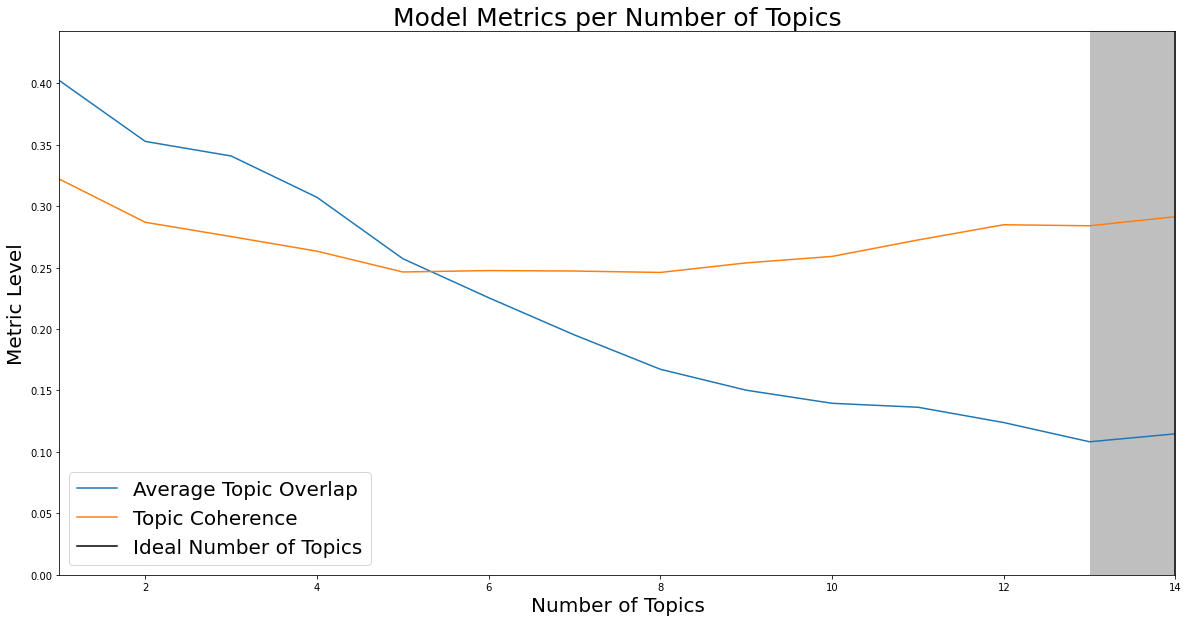

In [62]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()  